In [2]:
import pandas as pd
import numpy as np
import h5py
#import illustris_python as il
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib widget
from tqdm import tqdm_notebook
#import skysurvey_pw as skysurvey
import skysurvey
import requests
import glob
import os

import h5py
from astropy.cosmology import Planck15 as cosmo

from photutils.aperture import CircularAperture,aperture_photometry
from astropy.wcs import WCS
from astropy.visualization import simple_norm
from astropy.io import fits

import warnings
from tqdm.notebook import tqdm

import pandas as pd
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

def convert_phot(aperture_sum,zp):
    return -2.5*np.log10(aperture_sum) + zp
def convert_phot_fnu(aperture_sum,zp):
    return 10**(np.log10(aperture_sum)-0.4*(zp-8.9))
    
def do_ap_phot(img_path,snx=0,sny=0,pix_list=None,pos_list=None,zp=0,ax=None,band=0,plot_colour='w',plot=False):
    #zp does not matter if we are just doing colours.
    img = fits.getdata(img_path)[band]
    h = fits.getheader(img_path)
    #wgt = 1/np.var(img)
    #print(img.shape,wgt.shape)
    #wcs = WCS(h)
    # First do the inner apperture with DLR <1
    if not pix_list:
        pix_list=[snx,sny]
         
    if not pos_list:
        pos_list=[snx,sny]
    pixscale_physical = 1000/h['CDELT1']/cosmo.h
    ap = CircularAperture(pix_list,r=pixscale_physical)
    phot_df = aperture_photometry(img, ap,error=0.1*img).to_pandas()
    
    res =convert_phot(phot_df['aperture_sum'],zp)
    #res_fnu =convert_phot_fnu(phot_df['aperture_sum'],zp)
    res_err = convert_phot(phot_df['aperture_sum_err'],zp)
    if plot:
        plot_ap =  CircularAperture(pos_list,r=1)
        ##ap.positions = 
        plot_ap.plot(ax=ax,alpha=0.15,color=plot_colour)
    return ap,res, res_err

    
def plot_step(data,cut_par, cut_val,plot_2bin=True,bins=None,f=None,ax=None,
              colour=None,bincolour=None,binlabel=None,labelext='',scatter=True,scatterlabel='DES5YR',
             binmarker='D',fillmeans=True):
    data = data[~pd.isna(data[[cut_par,'MURES','MUERR']])]
    if not f:
        f,ax=plt.subplots(figsize=(8,6.5))
    if not colour:
        colour='#5c068c'
    if scatter:
        if scatterlabel:
            label=scatterlabel
        else:
            label=None
        ax.scatter(data[cut_par],data['MURES'],marker='.',alpha=0.5,label=label,color=colour)
    if plot_2bin:
        left = data[data[cut_par]<cut_val]
        right = data[data[cut_par]>=cut_val]
        left_mean = np.average(left['MURES'],weights = 1/left['MUERR']**2)
        left_std = np.std(left['MURES'])/np.sqrt(len(left))
        right_mean = np.average(right['MURES'],weights = 1/right['MUERR']**2)
        right_std = np.std(right['MURES'])/np.sqrt(len(right))
        xleftmean = np.average(left[cut_par])
        xrightmean= np.average(right[cut_par])
        print('xleftmean: ',xleftmean, 'xlefterr: ',xleftmean,cut_val-xleftmean)
        print('xrightmean: ',xrightmean, 'xrighterr: ',xrightmean-cut_val,np.max(right[cut_par])-xrightmean)
        ax.errorbar([xleftmean,xrightmean],[left_mean,right_mean],
                    yerr=[left_std,right_std],xerr=[[xleftmean,xrightmean-cut_val],
                    [cut_val-xleftmean,np.max(right[cut_par])-xrightmean]],
                    marker='s',
                    markersize=15,color=colour,linestyle='none',mew=2,mec='k')
        if fillmeans:
            xlows = np.linspace(np.min(data[cut_par]),cut_val,100)
            ax.fill_between(xlows,left_mean-left_std,left_mean+left_std,color=colour,alpha=0.2)
            xhighs = np.linspace(cut_val,np.max(data[cut_par]),100)
            ax.fill_between(xhighs,right_mean-right_std,right_mean+right_std,color=colour,alpha=0.2)
    if bins!=None:
        if type(bins) in [list,np.ndarray]:
            pass
        elif type(bins) in [float,int,np.float32,np.float64,np.int32,np.int64]:
            bw = (data[cut_par].max()-data[cut_par].min())/bins
            binmax= data[cut_par].max()+bw
            bins = np.arange(data[cut_par].min(),binmax,bw)
        labelcounter=0
        for n,g in data.groupby(pd.cut(data[cut_par],bins=bins)):
            if len(g)>0:
                
                
                mean = np.average(g['MURES'],weights=1/g['MUERR']**2)
                #err = np.mean(g['MUERR'])/np.sqrt(len(g))
                err = np.std(g['MURES'])/np.sqrt(len(g))
                x=np.mean(g[cut_par])
                if bincolour:
                    colour=bincolour
                if binlabel:
                    if labelcounter==0:
                        label=binlabel
                        labelcounter+=1
                        ax.errorbar(x,mean,yerr=err,marker=binmarker,
                            color=colour,#plt.get_cmap('viridis')(norm(mass)),
                            mew=1,mec='k',markersize=10,label=label,alpha=0.95
                           )
                    else:
                        ax.errorbar(x,mean,yerr=err,marker=binmarker,
                            color=colour,#plt.get_cmap('viridis')(norm(mass)),
                            mew=1,mec='k',markersize=10,alpha=0.95
                           )
                else:
                    ax.errorbar(x,mean,yerr=err,marker=binmarker,
                            color=colour,#plt.get_cmap('viridis')(norm(mass)),
                            mew=1,mec='k',markersize=10,alpha=0.95
                           )
                    
                
    return f,ax

def plot_scatter(data,x_par,y_par,x_err,y_err,bins=None,f=None,ax=None,
              colour=None,bincolour=None,binlabel=None,labelext='',scatter=True,scatterlabel='DES5YR',
             binmarker='D',how=np.mean):
    data = data[~pd.isna(data[[x_par,y_par,y_err]])]
    if not f:
        f,ax=plt.subplots(figsize=(8,6.5))
    if not colour:
        colour='#5c068c'
    if scatter:
        if scatterlabel:
            label=scatterlabel
        else:
            label=None
        ax.scatter(data[x_par],data[y_par],marker='.',alpha=0.5,label=label,color=colour)
    if bins!=None:
        if type(bins) in [list,np.ndarray]:
            pass
        elif type(bins) in [float,int,np.float32,np.float64,np.int32,np.int64]:
            bw = (data[x_par].max()-data[x_par].min())/bins
            binmax= data[x_par].max()+bw
            bins = np.arange(data[x_par].min(),binmax,bw)
        labelcounter=0
        for n,g in data.groupby(pd.cut(data[x_par],bins=bins)):
            if len(g)>0:
                #print('plotting in bins')                
                mean = np.average(g[y_par],weights=1/g[y_err]**2)
                #err = np.mean(g['MUERR'])/np.sqrt(len(g))
                err = np.std(g[y_par])/np.sqrt(len(g))
                x=np.mean(g[x_par])
                if bincolour:
                    colour=bincolour
                if binlabel:
                    if labelcounter==0:
                        label=binlabel
                        labelcounter+=1
                        ax.errorbar(x,mean,yerr=err,marker=binmarker,
                            color=colour,#plt.get_cmap('viridis')(norm(mass)),
                            mew=2,mec='k',markersize=15,label=label,alpha=0.95
                           )
                        #print('plotted errorbar',x,mean,err)
                    else:
                        ax.errorbar(x,mean,yerr=err,marker=binmarker,
                            color=colour,#plt.get_cmap('viridis')(norm(mass)),
                            mew=2,mec='k',markersize=15,alpha=0.95
                           )
                        #print('plotted errorbar',x,mean,err)
                else:
                    ax.errorbar(x,mean,yerr=err,marker=binmarker,
                            color=colour,#plt.get_cmap('viridis')(norm(mass)),
                            mew=2,mec='k',markersize=15,alpha=0.95
                           )
                
    return f,ax




def get_step(data,cut_par,cut_val,verbose=True):
    #cut_par_err = cut_par+cut_par_err_ext
    data = data[~pd.isna(data[[cut_par,'MURES','MUERR']])]
    left = data[data[cut_par]<cut_val]
    right = data[data[cut_par]>=cut_val]
    left_mean = np.average(left['MURES'],weights = 1/left['MUERR']**2)
    left_stderr = np.std(left['MURES'])/np.sqrt(len(left))
    left_weighted_stderr = np.sqrt(1/np.sum(1/left['MUERR']**2))
    right_mean = np.average(right['MURES'],weights = 1/right['MUERR']**2)
    right_stderr = np.std(right['MURES'])/np.sqrt(len(right))
    right_weighted_stderr = np.sqrt(1/np.sum(1/right['MUERR']**2))
    if verbose:
        print('Splitting at %s = %.3f'%(cut_par,cut_val))
        #print('Mean mures Low %s: %.3f+/-%.3f'%(cut_par,left_mean,left_stderr), 'Mean mures High %s: %.3f+/-%.3f'%(cut_par,right_mean,right_stderr))
        #print('Weighted stderrs. Left: %.3f, right %.3f'%(left_weighted_stderr,right_weighted_stderr))
        print('Step: %.3f+/-%.3f mag'%(left_mean - right_mean, np.sqrt(left_stderr**2 + right_stderr**2)))
        print('Significance: %.2f sigma'%((left_mean - right_mean)/np.sqrt(left_stderr**2 + right_stderr**2)))
    return left_mean - right_mean, np.sqrt(left_stderr**2 + right_stderr**2)


# get d_DLR

def get_DLR_ABT(x_pos, y_pos,  A_IMAGE, B_IMAGE, orientation_ellip, angsep):
    '''Function for calculating the DLR of a galaxy - SN pair (taken from dessne)'''
    #print('Inputs: ',x_pos, y_pos,  A_IMAGE, B_IMAGE, orientation_ellip, angsep)
   
    # angle between RA-axis and SN-host vector
    GAMMA = np.arctan(-y_pos/x_pos)
    #print('GAMMA',GAMMA)
    # angle between semi-major axis of host and SN-host vector
    PHI = orientation_ellip + GAMMA # angle between semi-major axis of host and SN-host vector
    #print('PHI',PHI)
    rPHI = A_IMAGE*B_IMAGE/np.sqrt((A_IMAGE*np.sin(PHI))**2 +
                                     (B_IMAGE*np.cos(PHI))**2)
    #print('rPHI',rPHI)
    # directional light radius
    #  where 2nd moments are bad, set d_DLR = 99.99
    d_DLR = angsep/rPHI

    return d_DLR
def angles(x_pos,y_pos,orientation_ellip):# angle between RA-axis and SN-host vector
    GAMMA = np.arctan(-y_pos/x_pos)
    #print('GAMMA',GAMMA)
    # angle between semi-major axis of host and SN-host vector
    PHI = orientation_ellip + GAMMA # angle between semi-major axis of host and SN-host vector
    print(GAMMA,PHI)
    print(np.rad2deg(GAMMA),np.rad2deg(PHI))

def dtd_pl(age, A=2.11e-13, beta=-1.13, t0=40):
        """Default delay time distribution function."""
        p = ((age*1000 < t0)*0) + ((age*1000>t0)*A * (age**beta))
        #if age*1000 < t0:
        #    return 0
        return p

def get_hostid(hostfunc=dtd_pl,ages=None):
    rates = hostfunc(ages,)
    print(rates)
    ids = np.random.choice(np.arange(len(ages)),p=rates/np.sum(rates))
    print(ids)
    return ids

# abstract it all into a single func

def get_host(ages,A=2.11e-13, beta=-1.13, t0=40):
    p = ((ages*1000 < t0)*0) + ((ages*1000>t0)*A * (ages**beta))
    return np.random.choice(np.arange(len(ages)),p=p/np.sum(p))


def get_metallicity(hostId,galcat):
    return galcat['metallicity'].iloc[hostId]
def get_progage(hostId,galcat):
    return galcat['age'].iloc[hostId]
from scipy.special import expit
from scipy.stats import norm
def x1_g24_age_metallicity(**kwargs):
    age =kwargs['age']
    metallicity = kwargs['metallicity']
    mu1,sig1,mu2,sig2,Km,rred,rblue,Kc,agesplit = [i for i in kwargs['params']]
    r = rred+((rblue-rred)*expit((age-agesplit)/Kc))
    
    #r=np.array(r)
    #print(r)
    Zsol=0
    x1low = (Km*(metallicity-Zsol))+mu2
    x1high = (Km*(metallicity-Zsol))+mu1
    norm1 = norm(x1high,sig1)
    norm2 = norm(x1low,sig2)
    choice = (np.random.rand(len(age))>r).astype(int)
    #choice = np.random.choice([0,1],p=[r,1-r])
    #print(choice)
    #print(choice.shape)
    n1rvs = norm1.rvs()
    n2rvs = norm2.rvs()
    #print('norm 1',n1rvs.shape,np.mean(n1rvs))
    #print('norm 2',n2rvs.shape,np.mean(n2rvs))
    x1=((choice==0)*n1rvs )+((choice==1)*n2rvs )
    #print(x1.shape)
    return x1

def age_step(**kwargs):
    age =kwargs['age']
    agesplit = kwargs['agesplit']
    Ka = kwargs['Ka']
    r = expit((age-agesplit)/Ka)
    choice = (np.random.rand(len(age))>r).astype(int)
    #print(age[:10],choice[:10])
    step = ((choice==0)*0.1)+((choice==1)*-0.1)
    #print(step[:10])
    magabs = -19.3+step
    #print(magabs[:10])
    return magabs

def distmod(mobs,x1,c,mabs=-19.3,alpha=-0.14,beta=3.15):
    return mobs-mabs -(alpha*x1 + beta*c)
def hubres(distmod,z,cosmo=None):
    if cosmo==None:
        from astropy.cosmology import Planck18 as cosmo
    return distmod - cosmo.distmod(z).value

    
g24_agemet_params = [0.25,0.55,-1.33,0.33,-0.3,0.18,0.98,-0.128,0.8]
new_model_for_metallicity = {'hostmet':{"func":get_metallicity,"kwargs":{"hostId":"@hostId"}}}
new_model_for_age = {'progage':{"func":get_progage,"kwargs":{"hostId":"@hostId"}}}

# First let us go and download the z=0 snapshot for a spiral galaxy in illustris TNG

In [3]:
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"eba6365a63ff327c63d284349c914245"}
def get(path, params=None,savepath=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    if 'content-disposition' in r.headers:
         if savepath==None:
             savepath=''
         
         filename = savepath+r.headers['content-disposition'].split("filename=")[1]
         #print('writing to file',filename)
         with open(filename, 'wb') as f:
             f.write(r.content)
         return filename # return the filename string
    return r

In [4]:
bases = {'TNG50-1':baseUrl+'TNG50-1/snapshots/96/',
        'TNG100-1':baseUrl+'TNG100-1/snapshots/96/'}
sim = 'TNG50-1'
thissim = get(bases[sim])
print(thissim['num_groups_subfind'])
nsubs = thissim['num_groups_subfind']

#halo = get(bases[sim]+f'halos/{haloId}/info.json')


5723981


In [5]:
star_fields = ['Masses','Coordinates','GFM_InitialMass','GFM_Metallicity','GFM_StellarFormationTime','GFM_InitialMass']#'GFM_StellarPhotometrics']#
gas_fields = ['Coordinates','StarFormationRate','GFM_Metallicity']
star_query = ''.join([i+',' for i in star_fields])
gas_query = ''.join([i+',' for i in gas_fields])
cutout_query = f'gas={gas_query[:-1]}&stars={star_query[:-1]}'
print(cutout_query)

gas=Coordinates,StarFormationRate,GFM_Metallicity&stars=Masses,Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,GFM_InitialMass


In [ ]:
get('http://www.tng-project.org/api/TNG100-1/files/stellar_sizes.99.hdf5')

In [39]:
import os
for i in range(1): #00
    subs=get(bases[sim]+f'subhalos/?limit=438&mass_stars__gte=8.0&offset={438*i}&order_by=mass_stars')
    
    subinfo=get(subs['results'][0]['url'])
    subhaloId = subs['results'][0]['id']
    savepath=f'data/{sim}/{subhaloId}/'
    if not os.path.isdir(savepath):
        os.mkdir(savepath)
    print('trying to save query',subinfo['cutouts']['subhalo']+'?'+cutout_query)
    snap_fn =get(subinfo['cutouts']['subhalo']+'?'+cutout_query,savepath=savepath)
    print('saving cutout query')
    print(cutout_query)

trying to save query http://www.tng-project.org/api/TNG50-1/snapshots/96/subhalos/423156/cutout.hdf5?gas=Coordinates,StarFormationRate,GFM_Metallicity&stars=Masses,Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,GFM_InitialMass
saving cutout query
gas=Coordinates,StarFormationRate,GFM_Metallicity&stars=Masses,Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,GFM_InitialMass


In [9]:


subhaloId = 549746
savepath=f'data/{sim}/{subhaloId}/'
if not os.path.isdir(savepath):
    os.mkdir(savepath)
print('trying to save query',subinfo['cutouts']['subhalo']+'?'+cutout_query)
snap_fn =get(subinfo['cutouts']['subhalo']+'?'+cutout_query,savepath=savepath)

trying to save query http://www.tng-project.org/api/TNG50-1/snapshots/96/subhalos/549746/cutout.hdf5?gas=Coordinates,StarFormationRate,GFM_Metallicity&stars=Masses,Coordinates,GFM_InitialMass,GFM_Metallicity,GFM_StellarFormationTime,GFM_InitialMass


In [ ]:
subs=get(bases[sim]+f'subhalos/?&mass_stars__gte={0.5}&limit=100&order_by=-mass_stars')
subs['count']

In [ ]:
star_formers = {}
star_bursts = {}
passives = {}
from tqdm import tqdm_notebook as tqdm
for sub in tqdm(subs['results']):
    thissub = get(sub['url'])
    mass_stars = thissub['mass_stars']
    sfr = thissub['sfr']
    ssfr = sfr/mass_stars
    if ssfr>10:
        star_bursts[sub['id']]=[mass_stars,sfr,ssfr]
    elif ssfr <0.1:
        passives[sub['id']]=[mass_stars,sfr,ssfr]
    else:
        star_formers[sub['id']]=[mass_stars,sfr,ssfr]

In [ ]:
mysubhaloIds = []
dirs = glob.glob(f'data/{sim}/*/')

for dirname in tqdm(dirs):
    subhaloId = dirname.split('/')[-2]
    mysubhaloIds.append(int(subhaloId))

np.savetxt(f'data/{sim}/subhaloId_list.txt',np.array(mysubhaloIds))

In [ ]:
query = ''
get(bases[sim]+'groupcat-99/?'+query)

In [9]:
dirs = glob.glob(f'data/{sim}/*/96*')
dirs

[]

In [ ]:
star_formers = {}
star_bursts = {}
passives = {}
from tqdm import tqdm_notebook as tqdm

dirs = glob.glob(f'data/{sim}/*/96/')

for dirname in tqdm(dirs[:1000]):
    subhaloId = dirname.split('/')[-2]
    thissub =get(bases[sim]+f'subhalos/{subhaloId}')
    
    mass_stars = thissub['mass_stars']
    
    if mass_stars>0:
        sfr = thissub['sfr']
        ssfr = sfr/mass_stars
        if ssfr>10:
            star_bursts[subhaloId]=[mass_stars,sfr,ssfr]
        elif ssfr <0.1:
            passives[subhaloId]=[mass_stars,sfr,ssfr]
        else:
            star_formers[subhaloId]=[mass_stars,sfr,ssfr]

In [ ]:
star_formers['718309']

In [ ]:
SFmeta = pd.DataFrame(star_formers)
SFmeta = SFmeta.T
SFmeta.rename(columns={0:'mass_stars',1:'sfr',2:'ssfr'},inplace=True)

SBmeta = pd.DataFrame(star_bursts)
SBmeta = SBmeta.T
SBmeta.rename(columns={0:'mass_stars',1:'sfr',2:'ssfr'},inplace=True)

passivemeta = pd.DataFrame(passives)
passivemeta = passivemeta.T
passivemeta.rename(columns={0:'mass_stars',1:'sfr',2:'ssfr'},inplace=True)

galmeta = pd.concat([SFmeta,SBmeta,passivemeta])


In [6]:
galmeta=pd.read_csv(f'data/{sim}/galmeta.csv',index_col=0)
len(galmeta)

853

In [ ]:
passivemeta['sfr'] = np.clip(passivemeta['sfr'],a_min=0.0001,a_max=None)

In [ ]:
f,ax=plt.subplots(figsize=(8,6.5))

#ax.scatter(np.log10(SFmeta['mass_stars'])+10,np.log10(SFmeta['sfr']),label='Star Forming')
#ax.scatter(np.log10(SBmeta['mass_stars'])+10,np.log10(SBmeta['sfr']),label='Star Burst')
ax.scatter(np.log10(galmeta['mass_stars'])+10,np.log10(galmeta['sfr']),label='All')

ax.set_xlabel('log Stellar Mass',size=22)
ax.set_ylabel('log Star Formation Rate',size=22)
ax.tick_params(which='both',direction='in',labelsize=15)

In [33]:
import glob


In [7]:
with h5py.File(f'data/{sim}/morphs_i.hdf5') as f:
                subfind_ids = np.array(f['subfind_id'])
                elongation_asymmetry = np.array(f['elongation_asymmetry'])
                ellipticity_asymmetry = np.array(f['ellipticity_asymmetry'])
                orientation_asymmetry = np.array(f['orientation_asymmetry'])
                rhalf_ellip = np.array(f['rhalf_ellip']) 
                sersic_ellip = np.array(f['sersic_ellip'])
                sersic_n = np.array(f['sersic_n'])
                sersic_rhalf = np.array(f['sersic_rhalf'])
                sersic_theta = np.array(f['sersic_theta'])
galaxy_morphs = pd.DataFrame(np.array([subfind_ids,  elongation_asymmetry,ellipticity_asymmetry,    orientation_asymmetry,    rhalf_ellip,    sersic_ellip,    sersic_n,sersic_rhalf, sersic_theta]).T,
                                     columns=['subfind_id','elongation_asymmetry', 'ellipticity_asymmetry','orientation_asymmetry','rhalf_ellip','sersic_ellip','sersic_n','sersic_rhalf','sersic_theta',])
subfind_ids = np.loadtxt(f'data/{sim}/subfind_ids.txt')

In [ ]:
galmeta_mcut.loc[655086]

In [35]:
subhaloIds = galmeta[(np.log10(galmeta['mass_stars'])>-1)].index.values

In [ ]:
gama_smf = {
    'Mstar':10.745,
'phi1':-2.437+0.0807,
'phi2':-3.201+0.0807,
'alpha1':-0.466,
'alpha2':-1.530,
#'rho_star':8.392
}

In [ ]:
def double_schechter(logM,logM_star,phi_star_1,alpha_1,phi_star_2,alpha_2):
    return np.log(10)*((phi_star_1*(10**((logM - logM_star)*(alpha_1))))+(phi_star_2*(10**((logM - logM_star)*(1+alpha_2)))))*\
                np.exp(-10**(logM-logM_star))

def double_schechter_driver(M,M_star,phi_star_1,alpha_1,phi_star_2,alpha_2):
    return ((phi_star_1*((M/M_star)**alpha_1)+phi_star_2*((M/M_star)**alpha_2))*\
                np.exp(-M/M_star))/M_star


#logM = np.arange(7,12,0.2)
M = np.logspace(7,12,10000)
dM = (M[1:]-M[:-1])*len(M)/10
dlogM = np.log10(dM)
f,ax=plt.subplots(figsize=(8,6.5))
ax.plot(M[1:],double_schechter_driver(M[1:],10**gama_smf['Mstar'],10**gama_smf['phi1'],gama_smf['alpha1'],10**gama_smf['phi2'],gama_smf['alpha2'])*(dM))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(5E-7,1)

In [ ]:
M_star = 10**gama_smf['Mstar']
phi1 = 10**gama_smf['phi1']
phi2 = 10**gama_smf['phi2']
galmeta['mass_stars_true'] = galmeta['mass_stars']*1E10
galmeta['SMF_weight'] = double_schechter_driver(galmeta['mass_stars_true'], M_star, phi1, gama_smf['alpha1'], phi2, gama_smf['alpha2'])

# Normalize the weights to get probabilities
galmeta['probability'] = galmeta['SMF_weight'] / galmeta['SMF_weight'].sum()

# Perform weighted random sampling
resampled_galmeta =galmeta.sample(n=len(galmeta), replace=True, weights=galmeta['probability'])

In [38]:
galmeta['mass_stars_true'] = galmeta['mass_stars']*1E10/ 0.6774


In [ ]:
f,ax=plt.subplots(figsize=(8,6.5))
#for n,g in resampled_galmeta.groupby(pd.cut(resampled_galmeta['mass_stars'],bins=[0.001,0.01,0.1,1,10,100,1000,10000])):
#    ax.scatter(n.mid,len(g))

for n,g in galmeta.groupby(pd.cut(galmeta['mass_stars_true'],bins=np.logspace(8,12,10))):
    ax.scatter(n.mid,len(g))
ax.set_xscale('log')
ax.set_yscale('log')

In [39]:
galmeta_mcut = galmeta[galmeta['mass_stars_true']>5E9]
#print(len(galmeta_mcut))
idx =galmeta_mcut.mass_stars.idxmin()

In [41]:
subhaloId = int(idx)
plot=False
if subhaloId ==638688:
    plot=True
#print(subhaloId)
snap_fn =f'data/{sim}/{subhaloId}/cutout_{subhaloId}.hdf5'
#print(os.path.isfile(snap_fn))
subinfo = get(bases[sim]+f'subhalos/{subhaloId}')
with h5py.File(snap_fn) as f:
    #gas=f['PartType0']
    stars=f['PartType4']
    star_inds = np.array(stars['GFM_StellarFormationTime'])>0
    metallicity = np.log10(stars['GFM_Metallicity'][star_inds]/0.0127)
    initial_mass = stars['GFM_InitialMass'][star_inds]*1e10/cosmo.h
    stellar_mass = stars['Masses'][star_inds]*1e10/cosmo.h
    minlen = len(stellar_mass)
    print(np.log10(np.sum(stellar_mass)))

9.699384


In [10]:
#Set some params
A=2.11e-13
beta=-1.13
t0=40

#all_sim = pd.DataFrame()


plot=False
for subhaloId in [549746]:#tqdm(galmeta_mcut.index.values):
    subhaloId = int(subhaloId)
    plot=False
    if subhaloId ==638688:
        plot=True
    #print(subhaloId)
    snap_fn =f'data/{sim}/{subhaloId}/cutout_{subhaloId}.hdf5'
    #print(os.path.isfile(snap_fn))
    subinfo = get(bases[sim]+f'subhalos/{subhaloId}')
    
    with h5py.File(snap_fn) as f:
        #gas=f['PartType0']
        stars=f['PartType4']
        star_inds = np.array(stars['GFM_StellarFormationTime'])>0
        metallicity = np.log10(stars['GFM_Metallicity'][star_inds]/0.0127)
        initial_mass = stars['GFM_InitialMass'][star_inds]*1e10/cosmo.h
        stellar_mass = stars['Masses'][star_inds]*1e10/cosmo.h
        Ur = stars['GFM_StellarPhotometrics'][star_inds,0]-(stars['GFM_StellarPhotometrics'][star_inds,5]-0.16) # restframe U-r, correct SDSS r to Vega
        V = stars['GFM_StellarPhotometrics'][star_inds,2]
        gz = stars['GFM_StellarPhotometrics'][star_inds,4]-stars['GFM_StellarPhotometrics'][star_inds,7] # restframe g-z in AB
        x = stars['Coordinates'][star_inds,0] - subinfo['pos_x']
        y = stars['Coordinates'][star_inds,1] - subinfo['pos_y']
        stfs = np.array(stars['GFM_StellarFormationTime'][star_inds])
        if not os.path.isfile(f'data/{sim}/{subhaloId}/{subhaloId}_ages.dat'):
            zs = (1/stfs)-1
            # Convert to lookback time so we can do the DTD
            t = cosmo.lookback_time(zs)
            t=np.clip(t.value,a_min=0.05,a_max=None)
            np.savetxt(f'data/{sim}/{subhaloId}/{subhaloId}_ages.dat',t)
    ages = np.loadtxt(f'data/{sim}/{subhaloId}/{subhaloId}_ages.dat',dtype=float)
    if len(ages)>0:
        n_samp= np.max([1,int(len(ages)/minlen)])
        #print(f'Sampling {n_samp} SNe from {subhaloId}')
        galaxy_catalog = pd.DataFrame(np.array([ages,metallicity,initial_mass,stellar_mass,V,Ur,gz,x,y]).T,columns=['age','metallicity','initial_mass','mass','V','U-r','g-z','x_pos','y_pos'])
        masses = galaxy_catalog['initial_mass'].values
        #new_model_for_hostid = {"hostId":{"func":get_hostid,"kwargs":{'hostfunc':dtd_pl,"ages":ages,},"as":"hostId"}}


        full_model = {"hostId":{"func":np.random.choice,"kwargs":{"a":np.arange(len(ages)),
                            "p":(((ages*1000 < t0)*0) + ((masses*1e10/0.6774)*(ages*1000>t0)*A * (ages**beta)))/np.sum(((ages*1000 < t0)*0) + ((masses*1e10/0.6774)*(ages*1000>t0)*A * (ages**beta)))},
                              "as":"hostId"},
               'hostmet':{"func":get_metallicity,"kwargs":{"hostId":"@hostId",'galcat':galaxy_catalog},'as':"hostmet"},
               'progage':{"func":get_progage,"kwargs":{"hostId":"@hostId",'galcat':galaxy_catalog},'as':"progage"},
               "x1":{"func":x1_g24_age_metallicity,"kwargs":{"age":"@progage","metallicity":"@hostmet","params":g24_agemet_params},},
               "mabs":{"func":age_step,"kwargs":{"age":"@progage","agesplit":3,"Ka":-0.128},}
              }
        snia = skysurvey.SNeIa.from_draw(size=n_samp, 
                             model=full_model,
                             magabs={"mabs":"@mabs"}
                            # x1={"x1":"@x1"}
                            )
        drawn_gals = galaxy_catalog.iloc[snia.data['hostId']]
        r_pos = np.sqrt(drawn_gals['x_pos']**2+drawn_gals['y_pos']**2)
        mures = hubres(distmod(snia.data['magobs'],snia.data['x1'],snia.data['c']),snia.data['z'])
        if plot==True:
            f,ax=plt.subplots(figsize=(8,6.5))
            print(f'Drew {len(snia.data['x1'])} x1 values' )
            ax.scatter(galaxy_catalog['g-z'].iloc[snia.data['hostId']],snia.data['x1'],alpha=0.5)
            ax.set_xlim(-0.25,1.75)
            ax.set_xlabel('Very local $g-z$ colour',size=22)
            ax.set_ylabel('SN stretch ($x_1$)',size=22)
            ax.tick_params(which='both',direction='in',)
            f,ax=plt.subplots(figsize=(8,6.5))
            ax.scatter(galaxy_catalog['g-z'].iloc[snia.data['hostId']],snia.data['magabs'],alpha=0.5)
            ax.set_xlim(-0.25,1.75)
            ax.set_xlabel('Very local $g-z$ colour',size=22)
            ax.set_ylabel('M_B',size=22)
            ax.tick_params(which='both',direction='in',)
            
            
            f,ax=plt.subplots(figsize=(8,6.5))
            ax.scatter(galaxy_catalog['g-z'].iloc[snia.data['hostId']],mures,alpha=0.5)
            ax.set_xlim(-0.25,1.75)
            ax.set_xlabel('Very local $g-z$ colour',size=22)
            ax.set_ylabel('MURES',size=22)
            ax.tick_params(which='both',direction='in',)
            f,ax=plt.subplots(figsize=(8,6.5))
            ax.scatter(r_pos,snia.data['x1'],alpha=0.5)
            
            mydf = snia.data
            mydf['r_pos'] = r_pos.values
            for n,g in mydf.groupby(pd.cut(mydf['r_pos'],bins=np.arange(0,25,5))):
                ax.errorbar(n.mid,g['x1'].mean(),yerr=g['x1'].std()/np.sqrt(len(g)),markersize=10,marker='D',color='navy')
            ax.set_xlim(0,25)
            ax.set_xlabel('Projected distance from host centre (kpc)',size=22)
            ax.set_ylabel('SN stretch ($x_1$)',size=22)
            ax.tick_params(which='both',direction='in',)
        try:
            get(subinfo['supplementary_data']['skirt_images']['fits_pogs'],savepath=f'data/{sim}/{subhaloId}/')
        except:
            print('failed to load skirt image')
            continue
        
        
        try:
            this_subhalo_morph = galaxy_morphs.iloc[np.where(subfind_ids==subhaloId)[0]]
        except:
            print('failed to load morph')
            continue
        hdul = fits.open(f'data/{sim}/{subhaloId}/broadband_{subhaloId}.fits')
        h = hdul[0].header
        if plot==True:
            print('made it to imshow')
            f,ax=plt.subplots(figsize=(8,8))
            boxsizex = h['CDELT1']*h['NAXIS1']*cosmo.h/1000
            xmin=xmax = boxsizex/2
            
            boxsizey = h['CDELT2']*h['NAXIS2']*cosmo.h/1000
            ymin=ymax = boxsizex/2
            ax.imshow(hdul[0].data[0],cmap='Greys',norm='log',origin='lower',extent=[-xmin,xmax,-ymin,ymax])
            ax.scatter(drawn_gals['x_pos'],drawn_gals['y_pos'],marker='o',color='navy',s=5,alpha=0.5)
            ax.set_xlim(-25,25)
            ax.set_ylim(-25,25)
            
            xs = np.linspace(-20,20,100)
            ys = xs*np.tan(this_subhalo_morph['orientation_asymmetry'].values[0])
            ax.plot(xs,ys,ls='--',color='c')
        
        drawn_gals['x_pix'] = (drawn_gals['x_pos']*1000/h['CDELT1']/cosmo.h)+(h['NAXIS1']/2)
        drawn_gals['y_pix'] = (drawn_gals['y_pos']*1000/h['CDELT2']/cosmo.h)+(h['NAXIS2']/2)
        drawn_gals['r_pix'] = np.sqrt((drawn_gals['x_pos']*1000/h['CDELT1']/cosmo.h)**2 + (drawn_gals['y_pos']*1000/h['CDELT2']/cosmo.h)**2)
        
        # rhalf_ellip  The semimajor axis of an elliptical aperture containing 50% of the light, assuming that the center is the point that minimizes the asymmetry and that the total is at rmax_ellip.
        # if elongation = a/b, then the semiminor axis of that aperture is rhalf_ellip/elongation
        #print(this_subhalo_morph)
        A_IMAGE =this_subhalo_morph['rhalf_ellip'].values*(1/0.68)
        B_IMAGE = this_subhalo_morph['rhalf_ellip'].values*(1/0.68)/this_subhalo_morph['elongation_asymmetry'].values[0]
        drawn_gals['d_DLR'] = get_DLR_ABT(drawn_gals['x_pos'].values,drawn_gals['y_pos'].values,A_IMAGE,B_IMAGE,this_subhalo_morph['orientation_asymmetry'].values[0],drawn_gals['r_pix'].values)
        pos_list = [(drawn_gals[['x_pos','y_pos']].iloc[i]) for i in range(len(drawn_gals))]
        pix_list = [(drawn_gals[['x_pix','y_pix']].iloc[i]) for i in range(len(drawn_gals)) ]
        band_mags = {}
        
        for counter,band in enumerate(['g','r','i','z']):
            apps,mags, magerrs=do_ap_phot(f'data/{sim}/{subhaloId}/broadband_{subhaloId}.fits',pos_list=pos_list,pix_list=pix_list,ax=ax,band=counter,plot=plot)
            band_mags[band] = mags
        drawn_gals['localrestframe_gz'] = band_mags['g'].values - band_mags['z'].values
        sim_data = snia.data.join(drawn_gals.reset_index(drop=True))
        sim_data['MURES'] = mures
        sim_data['MUERR'] = 0.1
        #print(galmeta.loc[str(subhaloId)]['mass_stars'])
        sim_data['globalmass'] = galmeta.loc[subhaloId]['mass_stars']
        sim_data['globalsfr'] = galmeta.loc[subhaloId]['sfr']
        sim_data['globalssfr'] = galmeta.loc[subhaloId]['ssfr']
        sim_data.to_hdf(f'simout/{subhaloId}_skysurvey_out.h5',key='main')

#all_sim.to_hdf('all_sim.h5',key='main')

KeyError: "Unable to open object (object 'PartType4' doesn't exist)"

# supplementary stuff to download
- e Stellar Projected sizes
- K SDSS ugriz and UVJ Photometry/Colors with Dust (only TNG100-1)
- (l) SKIRT Synthetic Images and Optical Morphologies (only for M>9.5)
- (w) Multi-band (UV to submm) Photometry and SEDs M>8

In [59]:
results = []
for subhaloId in tqdm(galmeta_mcut.index.values):
    fpath = f'simout/{subhaloId}_skysurvey_out.h5'
    try:
        results.append(pd.read_hdf(fpath))
    except:
        pass
all_sim = pd.concat([r for r in results if r is not None])

  0%|          | 0/944 [00:00<?, ?it/s]

In [63]:
from datetime import datetime
all_sim.to_hdf(f'simout/{sim}_skysurvey_out_{datetime.now().strftime('%Y%m%d')}.h5', key='main',mode='w')

In [64]:
today = datetime.now().strftime('%Y%m%d')
print(today)

20250602


In [65]:
all_sim = pd.read_hdf(f'simout/{sim}_skysurvey_out_{today}.h5')
all_sim['globalmass'] = all_sim['globalmass']*1E10/cosmo.h

In [66]:
all_sim['log_globalmass'] = np.log10(all_sim['globalmass'])

In [46]:
all_sim = all_sim[all_sim['d_DLR']<4]

Text(0.5, 0, 'Local restframe $g-z$ colour')

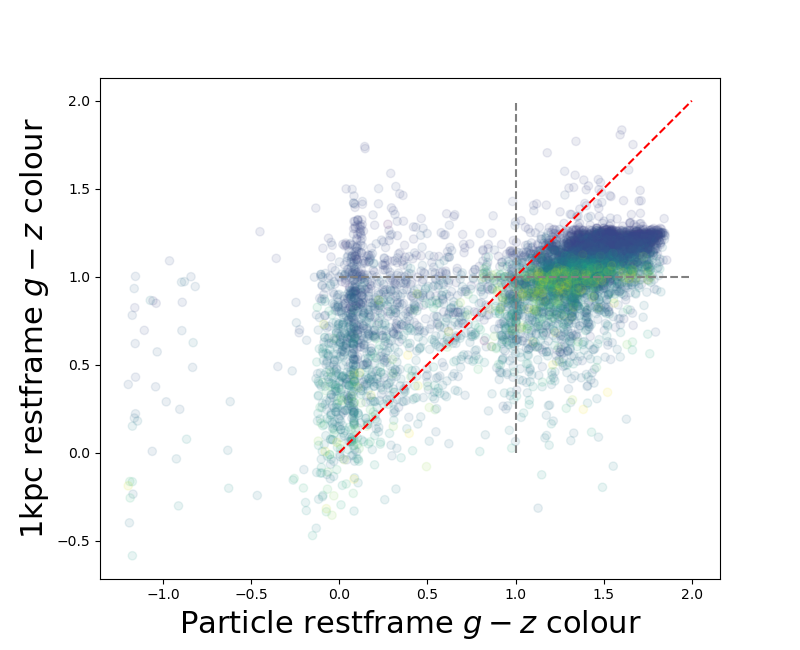

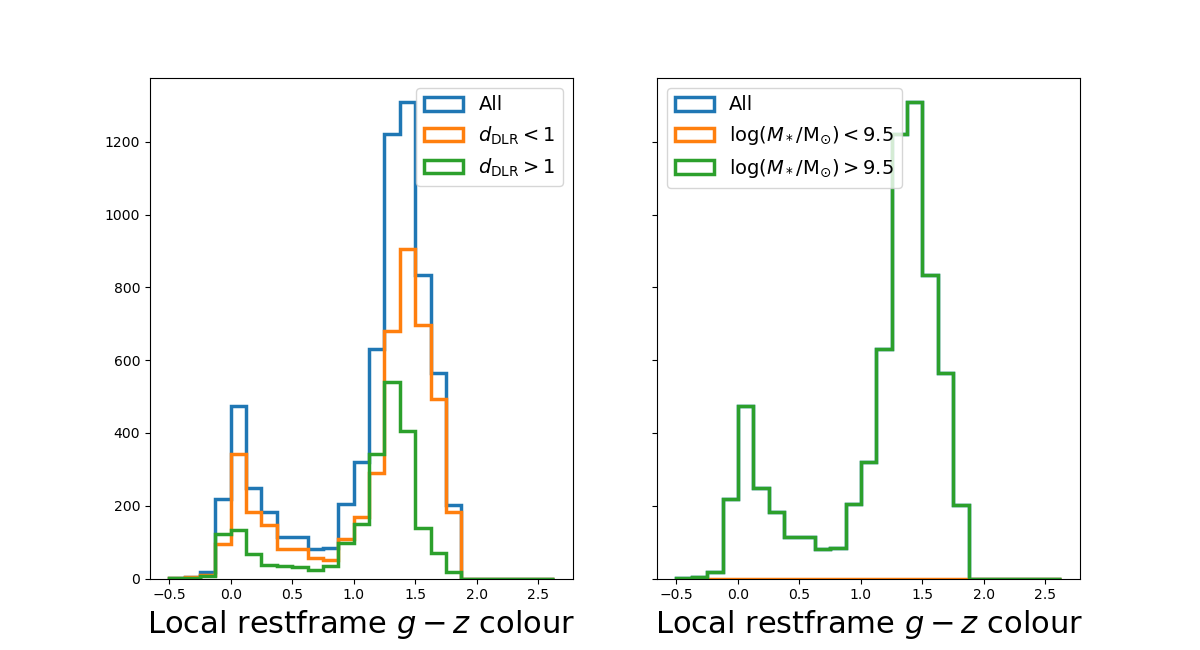

In [11]:
f,ax=plt.subplots(figsize=(8,6.5))
ax.scatter(all_sim['g-z'],all_sim['localrestframe_gz'],alpha=0.1,c=all_sim['d_DLR'],cmap='viridis')

#ax.legend(fontsize=14)
ax.set_xlabel('Particle restframe $g-z$ colour',size=22)
ax.set_ylabel('1kpc restframe $g-z$ colour',size=22)
ax.plot(np.linspace(0,2,50),np.linspace(0,2,50),color='r',ls='--')
ax.vlines(1,0,2,color='grey',ls='--')
ax.hlines(1,0,2,color='grey',ls='--')

f,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6.5),sharey=True)
ax1.hist(all_sim['g-z'],bins=np.arange(-0.5,2.75,0.125),label='All',histtype='step',lw=2.5)
ax1.hist(all_sim[all_sim['d_DLR']<1]['g-z'],bins=np.arange(-0.5,2.75,0.125),label=r'$d_{\mathrm{DLR}}<1$',histtype='step',lw=2.5)
ax1.hist(all_sim[all_sim['d_DLR']>=1]['g-z'],bins=np.arange(-0.5,2.75,0.125),label=r'$d_{\mathrm{DLR}}>1$',histtype='step',lw=2.5)
ax1.legend(fontsize=14)
ax1.set_xlabel('Local restframe $g-z$ colour',size=22)


ax2.hist(all_sim['g-z'],bins=np.arange(-0.5,2.75,0.125),label='All',histtype='step',lw=2.5)
ax2.hist(all_sim[all_sim['log_globalmass']<9.5]['g-z'],bins=np.arange(-0.5,2.75,0.125),label=r'$\log(M_*/\mathrm{M}_{\odot})<9.5$',histtype='step',lw=2.5)
ax2.hist(all_sim[all_sim['log_globalmass']>=9.5]['g-z'],bins=np.arange(-0.5,2.75,0.125),label=r'$\log(M_*/\mathrm{M}_{\odot})>9.5$',histtype='step',lw=2.5)
ax2.legend(fontsize=14)
ax2.set_xlabel('Local restframe $g-z$ colour',size=22)

In [259]:
all_sim['globalmass'].max()

1596471803956.3035

In [260]:
len(all_sim)

6908

/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/2327019685.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for n,g in all_sim.groupby(pd.cut(all_sim['d_DLR'],bins=[0,0.5,1,4,])):
/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/2327019685.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(g['localrestframe_gz'],g['x1'],alpha=0.1,label=f'${n.left} < d_DLR < {n.right}$',c=c,marker=marker)
/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/2327019685.py:11: 

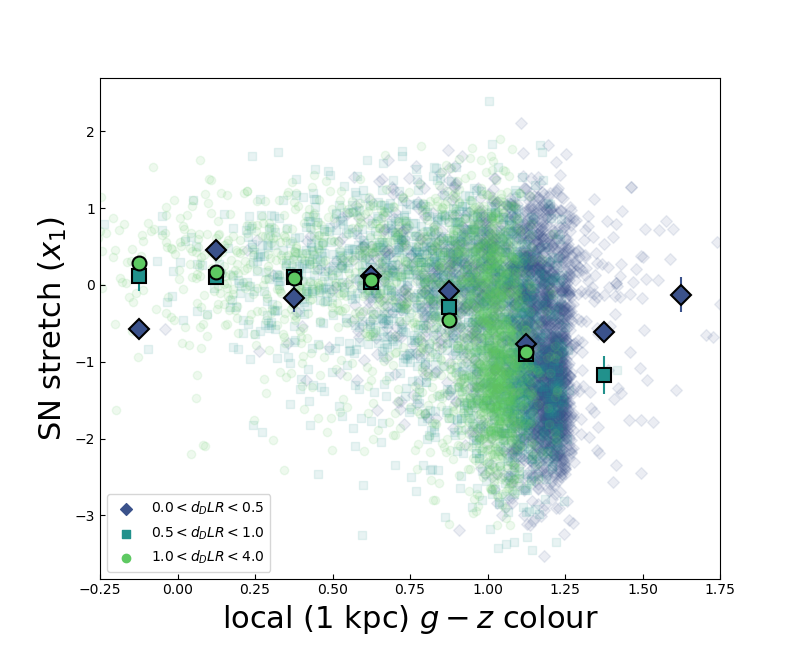

In [12]:
f,ax=plt.subplots(figsize=(8,6.5))
import seaborn as sns
import itertools
palette = itertools.cycle(sns.color_palette('viridis',n_colors=3))
markers = itertools.cycle(['D','s','o','^'])
for n,g in all_sim.groupby(pd.cut(all_sim['d_DLR'],bins=[0,0.5,1,4,])):
    c=next(palette)
    marker=next(markers)
    ax.scatter(g['localrestframe_gz'],g['x1'],alpha=0.1,label=f'${n.left} < d_DLR < {n.right}$',c=c,marker=marker)
    
    for nc,gc in g.groupby(pd.cut(g['localrestframe_gz'],bins=[-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2])):
        if len(gc)>0:
            ax.errorbar(nc.mid,gc['x1'].mean(),yerr=gc['x1'].std()/np.sqrt(len(gc['x1'])),markersize=10,marker=marker,color=c,mec='k',mew=1.5)
    
ax.set_xlim(-0.25,1.75)
ax.set_xlabel('local (1 kpc) $g-z$ colour',size=22)
ax.set_ylabel('SN stretch ($x_1$)',size=22)
ax.tick_params(which='both',direction='in',)
leg = ax.legend()
for lh in leg.legend_handles:
    lh.set_alpha(1)

/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/383498700.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for n,g in all_sim.groupby(pd.cut(all_sim['age'],bins=[0,0.25,0.5,0.75,1,2,3,4,5,6,7,8,9,10,11,12,13])):
/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/383498700.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for n,g in all_sim.groupby(pd.cut(all_sim['age'],bins=[0,0.25,0.5,0.75,1,2,3,4,5,6,7,8,9,10,11,12,13])):
/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/383498700.py:24: FutureWarning: The default of observed=False is deprecated and will b

(0.0, 2.0)

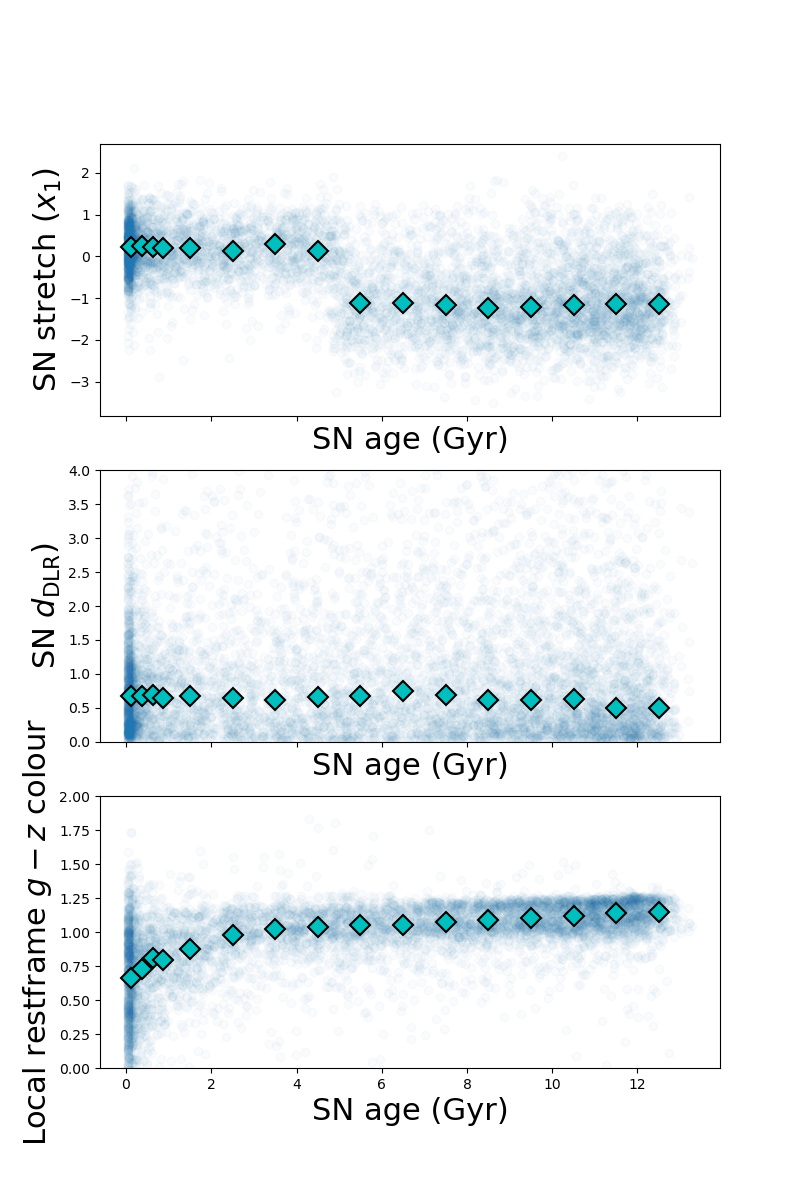

In [13]:
all_sim = all_sim[all_sim['d_DLR']<10]
f,(ax1,ax2,ax3)=plt.subplots(3,figsize=(8,12),sharex=True)
ax1.scatter(all_sim['age'],all_sim['x1'],alpha=0.025)

ax1.set_ylabel('SN stretch ($x_1$)',size=22)
ax1.set_xlabel('SN age (Gyr)',size=22)
for n,g in all_sim.groupby(pd.cut(all_sim['age'],bins=[0,0.25,0.5,0.75,1,2,3,4,5,6,7,8,9,10,11,12,13])):
    if len(g)>0:
        ax1.errorbar(n.mid,g['x1'].median(),yerr=g['x1'].std()/np.sqrt(len(g['x1'])),markersize=10,marker='D',color='c',mec='k',mew=1.5)

        

ax2.scatter(all_sim['age'],all_sim['d_DLR'],alpha=0.025)
for n,g in all_sim.groupby(pd.cut(all_sim['age'],bins=[0,0.25,0.5,0.75,1,2,3,4,5,6,7,8,9,10,11,12,13])):
    if len(g)>0:
        ax2.errorbar(n.mid,g['d_DLR'].median(),yerr=g['d_DLR'].std()/np.sqrt(len(g['d_DLR'])),markersize=10,marker='D',color='c',mec='k',mew=1.5)

ax2.set_ylabel(r'SN $d_{\mathrm{DLR}}$)',size=22)
ax2.set_xlabel('SN age (Gyr)',size=22)
ax2.set_ylim(0,4)


ax3.scatter(all_sim['age'],all_sim['localrestframe_gz'],alpha=0.025)
for n,g in all_sim.groupby(pd.cut(all_sim['age'],bins=[0,0.25,0.5,0.75,1,2,3,4,5,6,7,8,9,10,11,12,13])):
    if len(g)>0:
        ax3.errorbar(n.mid,g['localrestframe_gz'].median(),yerr=g['localrestframe_gz'].std()/np.sqrt(len(g['localrestframe_gz'])),markersize=10,marker='D',color='c',mec='k',mew=1.5)

ax3.set_ylabel(r'Local restframe $g-z$ colour',size=22)
ax3.set_xlabel('SN age (Gyr)',size=22)
ax3.set_ylim(0,2)

/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/307091416.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for n,g in all_sim.groupby(pd.cut(all_sim['age'],bins=bins)):
/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/307091416.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for n,g in all_sim.groupby(pd.cut(all_sim['age'],bins=bins)):


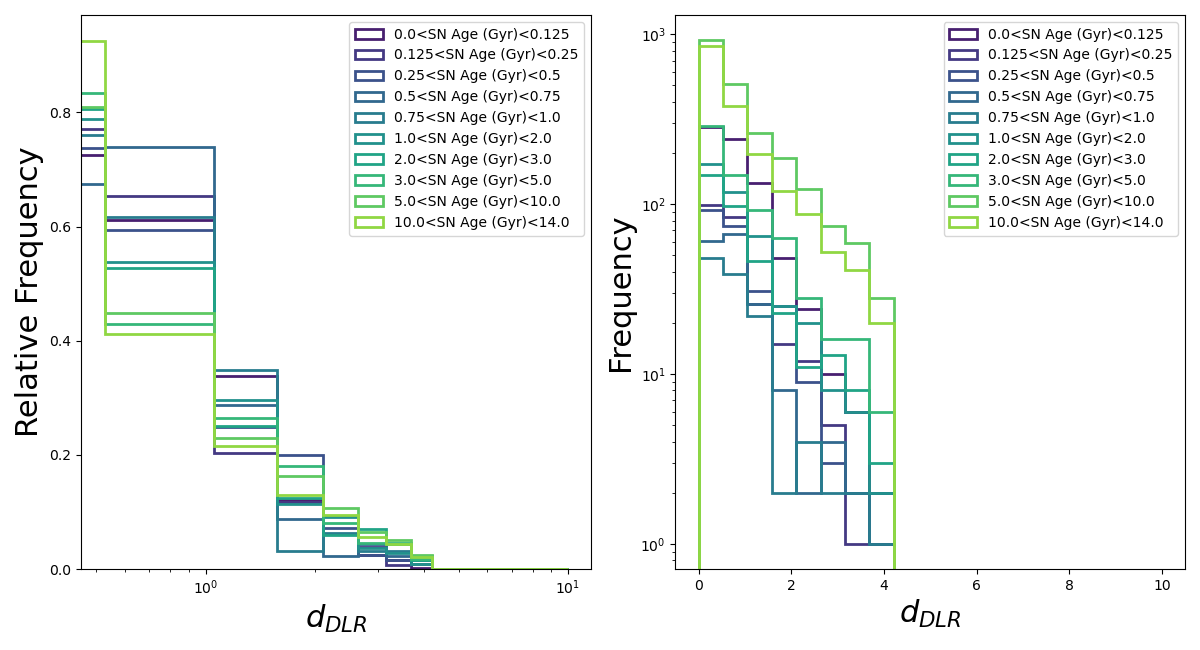

In [14]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6.5))
bins=[0,0.125,0.25,0.5,0.75,1,2,3,5,10,14]
palette = itertools.cycle(sns.color_palette('viridis',n_colors=len(bins)))
for n,g in all_sim.groupby(pd.cut(all_sim['age'],bins=bins)):
    if len(g)>0:
        c=next(palette)
        ax1.hist(g['d_DLR'],bins=np.linspace(0,10,20),density=True,lw=2,histtype='step',color=c,label=rf'{n.left}<SN Age (Gyr)<{n.right}')
ax1.legend()
ax1.set_xscale('log')
ax1.set_xlabel(r'$d_{DLR}$',size=22)
ax1.set_ylabel('Relative Frequency',size=22)


palette = itertools.cycle(sns.color_palette('viridis',n_colors=len(bins)))
for n,g in all_sim.groupby(pd.cut(all_sim['age'],bins=bins)):
    if len(g)>0:
        c=next(palette)
        ax2.hist(g['d_DLR'],bins=np.linspace(0,10,20),density=False,lw=2,histtype='step',color=c,label=rf'{n.left}<SN Age (Gyr)<{n.right}')
ax2.legend()
ax2.set_yscale('log')
ax2.set_xlabel(r'$d_{DLR}$',size=22)
ax2.set_ylabel('Frequency',size=22)
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/402351849.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for n,g in all_sim.groupby(pd.cut(all_sim['log_globalmass'],bins=bins)):


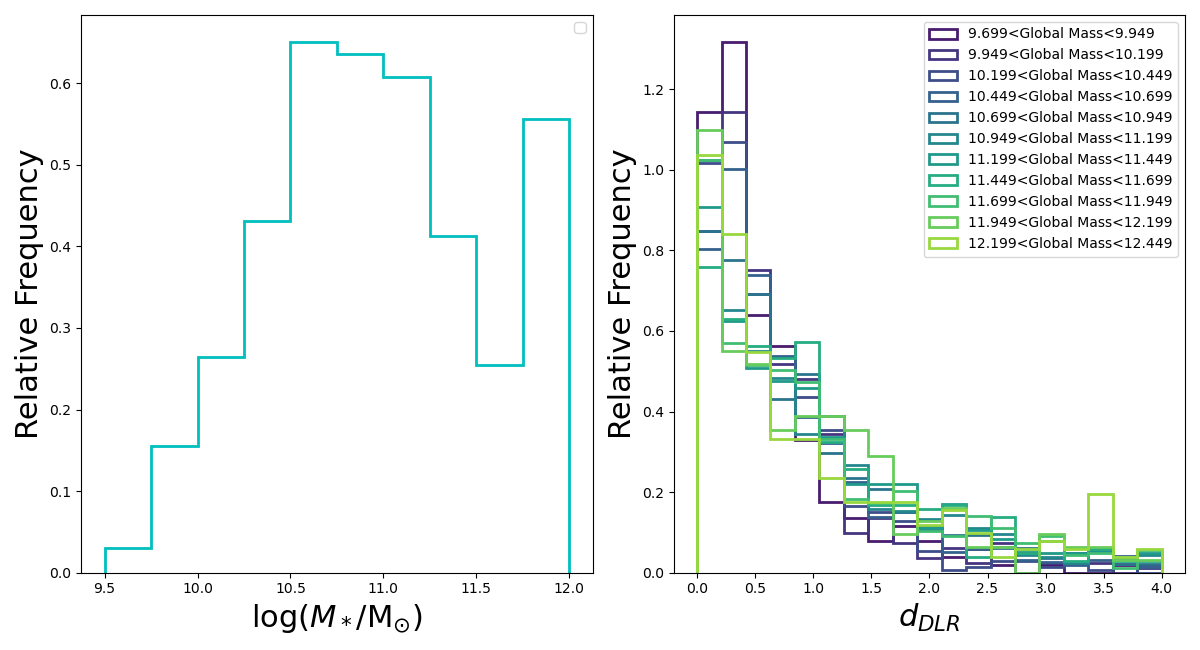

In [15]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6.5))
all_sim['log_globalmass'] = np.log10(all_sim['globalmass'])#+10
ax1.hist(all_sim['log_globalmass'],bins=np.arange(9.5,12.25,0.25),density=True,lw=2,histtype='step',color='c',)
ax1.legend()
#ax.set_yscale('log')
ax1.set_xlabel(r'$\log(M_*/\mathrm{M}_{\odot})$',size=22)
ax1.set_ylabel('Relative Frequency',size=22)

bins=np.arange(all_sim['log_globalmass'].min(),all_sim['log_globalmass'].max()+0.25,0.25)

palette = itertools.cycle(sns.color_palette('viridis',n_colors=len(bins)))
for n,g in all_sim.groupby(pd.cut(all_sim['log_globalmass'],bins=bins)):
    if len(g)>0:
        c=next(palette)
        ax2.hist(g['d_DLR'],bins=np.linspace(0,4,20),density=True,lw=2,histtype='step',color=c,label=rf'{n.left}<Global Mass<{n.right}')
ax2.legend()
#ax.set_yscale('log')
ax2.set_xlabel(r'$d_{DLR}$',size=22)
ax2.set_ylabel('Relative Frequency',size=22)
plt.tight_layout()

/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/2298451043.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for n,g in all_sim.groupby(pd.cut(all_sim['d_DLR'],bins=[0,0.25,0.5,0.75,1,2,3,4,])):
/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/2298451043.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  ax.errorbar(n.mid,g['x1'].mean(),yerr=g['x1'].std()/np.sqrt(len(gc['x1'])),markersize=10,marker=marker,color=c,mec='k',mew=1.5)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


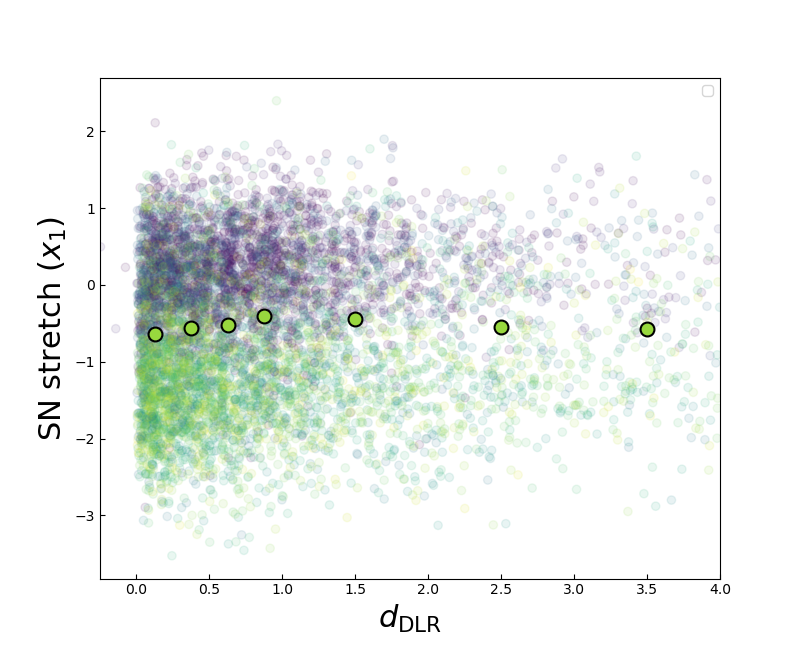

In [16]:
f,ax=plt.subplots(figsize=(8,6.5))
import seaborn as sns
import itertools
palette = itertools.cycle(sns.color_palette('viridis',n_colors=3))
#markers = itertools.cycle(['D','s','o','^'])
ax.scatter(all_sim['d_DLR'],all_sim['x1'],alpha=0.1,c=all_sim['age'],marker=marker)
for n,g in all_sim.groupby(pd.cut(all_sim['d_DLR'],bins=[0,0.25,0.5,0.75,1,2,3,4,])):
    if len(g)>0:
        ax.errorbar(n.mid,g['x1'].mean(),yerr=g['x1'].std()/np.sqrt(len(gc['x1'])),markersize=10,marker=marker,color=c,mec='k',mew=1.5)
    
ax.set_xlim(-0.25,4)
ax.set_xlabel(r'$d_{\mathrm{DLR}}$',size=22)
ax.set_ylabel('SN stretch ($x_1$)',size=22)
ax.tick_params(which='both',direction='in',)
leg = ax.legend()
for lh in leg.legend_handles:
    lh.set_alpha(1)

/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/1317893399.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for n,g in all_sim.groupby(pd.cut(all_sim['d_DLR'],bins=[0,0.5,1,4,])):


Text(0, 0.5, 'Relative Frequency')

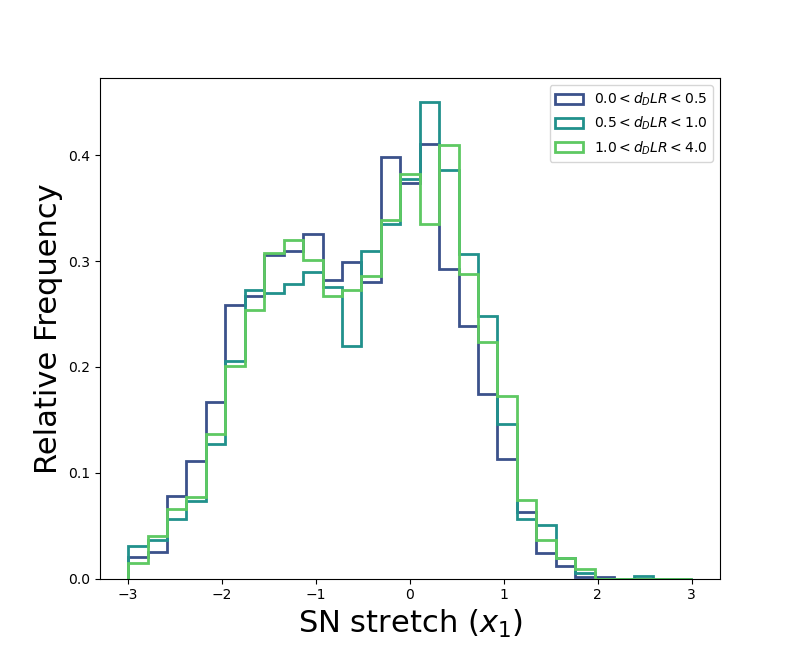

In [47]:
palette = itertools.cycle(sns.color_palette('viridis',n_colors=3))
f,ax=plt.subplots(figsize=(8,6.5))
for n,g in all_sim.groupby(pd.cut(all_sim['d_DLR'],bins=[0,0.5,1,4,])):
    c=next(palette)
    ax.hist(g['x1'],bins=np.linspace(-3,3,30),histtype='step',lw=2,color=c,label=f'${n.left} < d_DLR < {n.right}$',density=True)
ax.legend()
ax.set_xlabel('SN stretch ($x_1$)',size=22)
ax.set_ylabel('Relative Frequency',size=22)

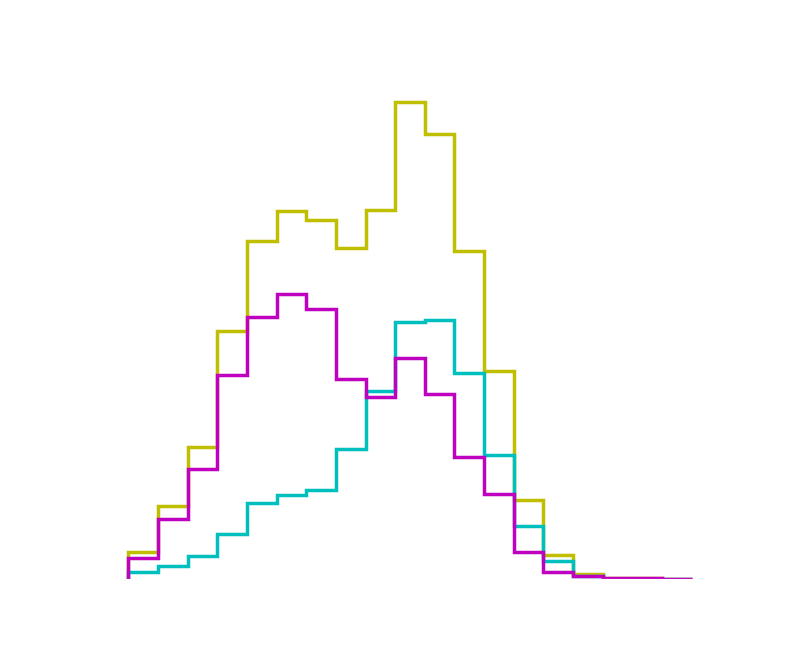

In [49]:
#palette = itertools.cycle(sns.color_palette('viridis',n_colors=3))
f,ax=plt.subplots(figsize=(8,6.5))
ax.hist(all_sim['x1'],bins=np.linspace(-3,3,20),histtype='step',linewidth=2.5,color='y',)
ax.hist(all_sim[all_sim['localrestframe_gz']<1]['x1'],bins=np.linspace(-3,3,20),histtype='step',linewidth=2.5,color='c',)
ax.hist(all_sim[all_sim['localrestframe_gz']>=1]['x1'],bins=np.linspace(-3,3,20),histtype='step',linewidth=2.5,color='m',)


ax.spines['bottom'].set_color('white')
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.spines['left'].set_color('w')
ax.spines['right'].set_visible(False)
#ax.xaxis.label.set_color('white')
ax.tick_params( colors='white',labelsize=16,top=False,right=False)
#ax.yaxis.set_ticklabels('')
ax.set_xlabel(r'Light curve width $x_1$',size=25,color='w')
plt.savefig('figs/x1_hist_tng.png',transparent=True)


/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/3467704033.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for n,g in all_sim.groupby(pd.cut(all_sim['d_DLR'],bins=[0,1,4,])):
/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/3467704033.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(g['localrestframe_gz'],g['MURES'],alpha=0.1,label=f'${n.left} < d_DLR < {n.right}$',c=c,marker=marker)
/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/3467704033.py:9: Fu

Text(0, 0.5, 'Relative Frequency')

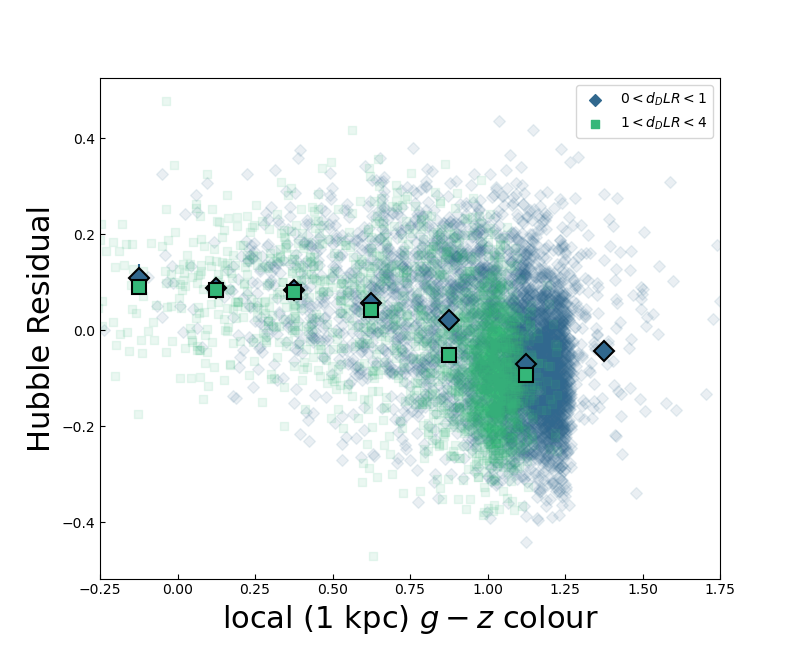

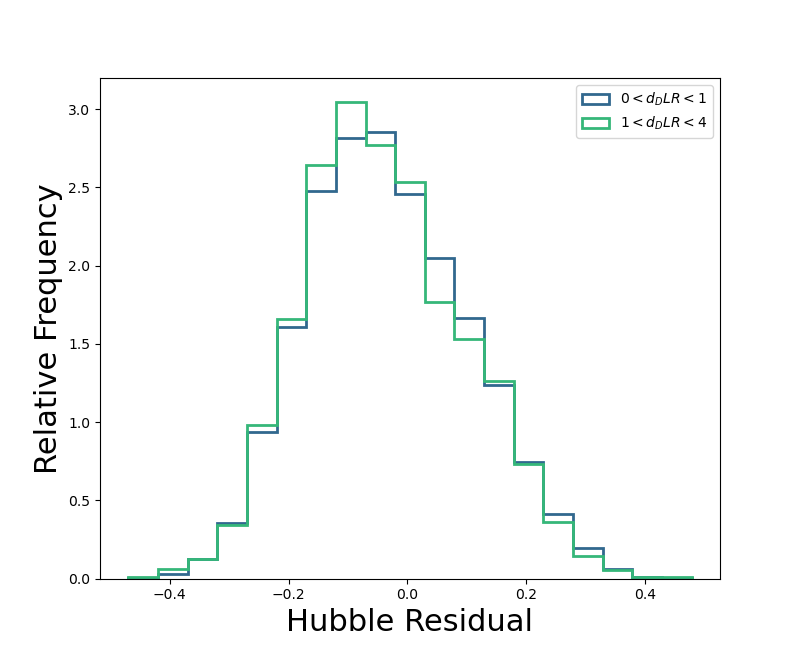

In [50]:
f,ax=plt.subplots(figsize=(8,6.5))
palette = itertools.cycle(sns.color_palette('viridis',n_colors=2))
markers = itertools.cycle(['D','s','o','^'])
for n,g in all_sim.groupby(pd.cut(all_sim['d_DLR'],bins=[0,1,4,])):
    c=next(palette)
    marker=next(markers)
    ax.scatter(g['localrestframe_gz'],g['MURES'],alpha=0.1,label=f'${n.left} < d_DLR < {n.right}$',c=c,marker=marker)
    
    for nc,gc in g.groupby(pd.cut(g['localrestframe_gz'],bins=[-0.25,0,0.25,0.5,0.75,1,1.25,1.5])):
        if len(gc)>0:
            ax.errorbar(nc.mid,gc['MURES'].mean(),yerr=gc['MURES'].std()/np.sqrt(len(gc['MURES'])),markersize=10,marker=marker,color=c,mec='k',mew=1.5)
    
ax.set_xlim(-0.25,1.75)
ax.set_xlabel('local (1 kpc) $g-z$ colour',size=22)
ax.set_ylabel('Hubble Residual',size=22)
ax.tick_params(which='both',direction='in',)
leg = ax.legend()
for lh in leg.legend_handles:
    lh.set_alpha(1)

palette = itertools.cycle(sns.color_palette('viridis',n_colors=2))
f,ax=plt.subplots(figsize=(8,6.5))
for n,g in all_sim.groupby(pd.cut(all_sim['d_DLR'],bins=[0,1,4])):
    c=next(palette)
    ax.hist(g['MURES'],bins=np.linspace(all_sim['MURES'].min(),all_sim['MURES'].max(),20),histtype='step',lw=2,color=c,label=f'${n.left} < d_DLR < {n.right}$',density=True)
ax.legend()
ax.set_xlabel('Hubble Residual',size=22)
ax.set_ylabel('Relative Frequency',size=22)

/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_29923/3134146521.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for n,g in all_sim.groupby(pd.cut(all_sim['d_DLR'],bins=[0,1,4,])):


Text(0, 0.5, 'Relative Frequency')

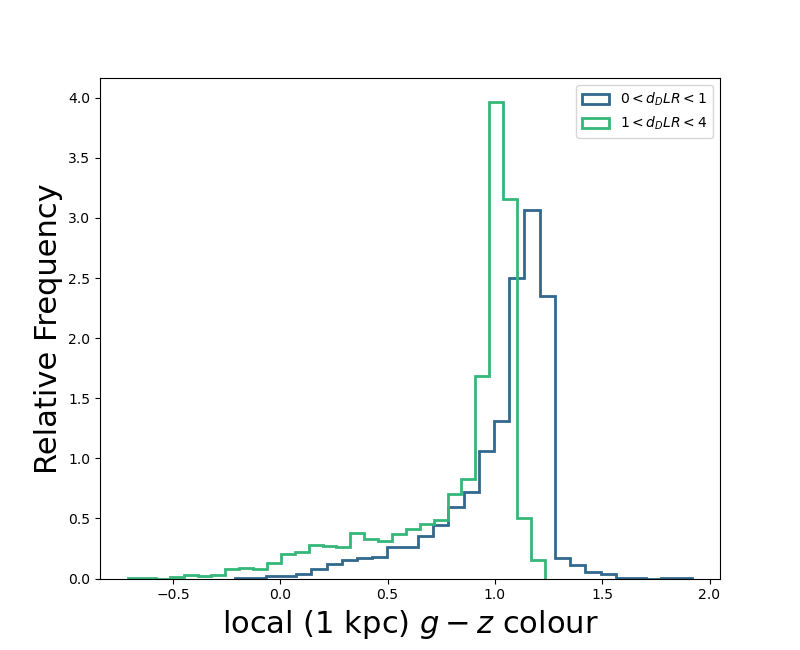

In [268]:
palette = itertools.cycle(sns.color_palette('viridis',n_colors=2))
f,ax=plt.subplots(figsize=(8,6.5))
for n,g in all_sim.groupby(pd.cut(all_sim['d_DLR'],bins=[0,1,4,])):
    c=next(palette)
    ax.hist(g['localrestframe_gz'],bins=30,histtype='step',lw=2,color=c,label=f'${n.left} < d_DLR < {n.right}$',density=True)
ax.legend()
ax.set_xlabel('local (1 kpc) $g-z$ colour',size=22)
ax.set_ylabel('Relative Frequency',size=22)

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/3012087557.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('Hubble Residual ($\mu_{\mathrm{res}}$)',size=22)
/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/3012087557.py:32: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('Hubble Residual ($\mu_{\mathrm{res}}$)',size=22)
/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/3379022560.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for n,g in data.groupby(pd.cut(data[cut_par],bins=bins)):
/var/folders/sk/qcx_g_xs2ysb

Splitting at localrestframe_gz = 0.500
Step: 0.143+/-0.006 mag
Significance: 22.58 sigma
xleftmean:  0.202899722948177 xlefterr:  0.202899722948177 0.29710027705182296
xrightmean:  0.9525945051942235 xrighterr:  0.4525945051942235 0.27235077859612766
Splitting at localrestframe_gz = 0.500
Step: 0.123+/-0.008 mag
Significance: 16.13 sigma
xleftmean:  0.32138754733924835 xlefterr:  0.32138754733924835 0.17861245266075165
xrightmean:  1.0603926591668071 xrighterr:  0.5603926591668071 0.7734115378670494


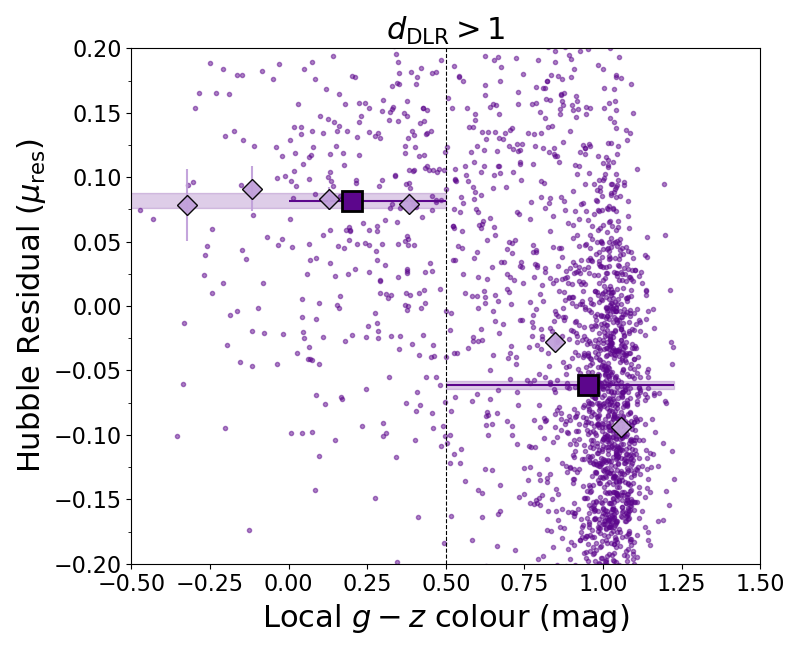

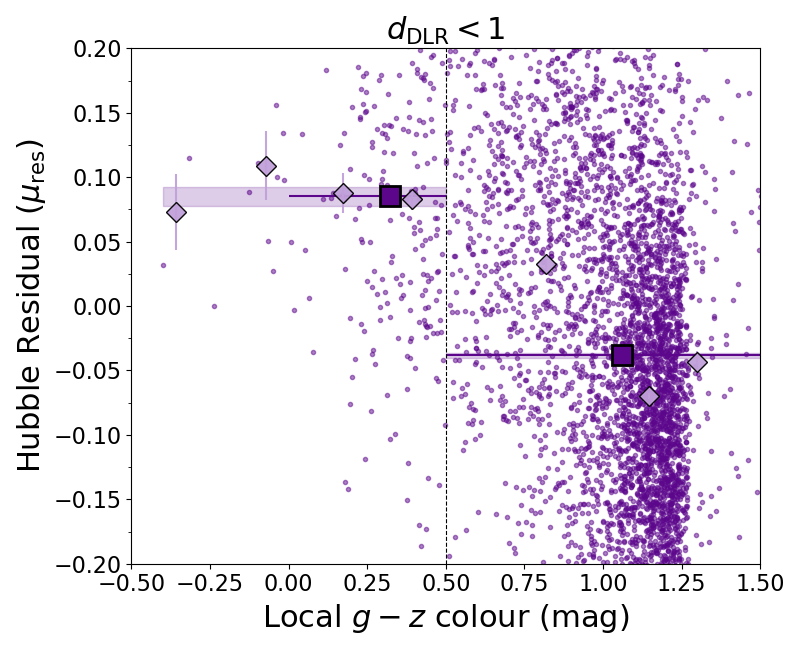

In [51]:
f,(ax1) = plt.subplots(figsize=(8,6.5),sharex=True)
data_highdlr = all_sim[all_sim['d_DLR']>1]
get_step(data_highdlr,'localrestframe_gz',0.5)
f,ax1=plot_step(data_highdlr,'localrestframe_gz',0.5,bins=[-0.5,-0.25,0,0.25,0.5,1,1.25,1.5,1.75,2,2.5,3],f=f,ax=ax1,colour='#5c068c',bincolour='#c1a0da',
                plot_2bin=True,labelext=r' $\log(M/M_{\odot})>10$',
               scatterlabel=False,binlabel=r'Weighted Means')
ax1.vlines(0.5,-0.2,0.2,ls='--',lw=0.8,color='k')
ax1.set_xlim(-0.5,1.5)
ax1.set_ylim(-0.2,0.2)
ax1.set_xlabel('Local $g-z$ colour (mag)',size=22)
ax1.set_ylabel('Hubble Residual ($\mu_{\mathrm{res}}$)',size=22)
ax1.set_title(r'$d_{\mathrm{DLR}}>1$',size=22)
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
ax1.tick_params(which='both',labelsize=16)
plt.tight_layout()
#plt.savefig(figdir+'UR_step_highDLR_%s.png'%fittype)
#plt.savefig(figdir+'UR_step_highDLR_%s.pdf'%fittype)



f,(ax1) = plt.subplots(figsize=(8,6.5),sharex=True)
data_lowdlr = all_sim[all_sim['d_DLR']<=1]
get_step(data_lowdlr,'localrestframe_gz',0.5)
f,ax1=plot_step(data_lowdlr,'localrestframe_gz',0.5,bins=[-0.5,-0.25,0,0.25,0.5,1,1.25,1.5,1.75,2,2.5,3],f=f,ax=ax1,colour='#5c068c',bincolour='#c1a0da',
                plot_2bin=True,labelext=r' $\log(M/M_{\odot})>10$',
               scatterlabel=False,binlabel=r'Weighted Means')
ax1.vlines(0.5,-0.2,0.2,ls='--',lw=0.8,color='k')
ax1.set_xlim(-0.5,1.5)
ax1.set_ylim(-0.2,0.2)
ax1.set_xlabel('Local $g-z$ colour (mag)',size=22)
ax1.set_ylabel('Hubble Residual ($\mu_{\mathrm{res}}$)',size=22)
ax1.set_title(r'$d_{\mathrm{DLR}}<1$',size=22)
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
ax1.tick_params(which='both',labelsize=16)
plt.tight_layout()
#plt.savefig(figdir+'UR_step_lowDLR_%s.png'%fittype)
#plt.savefig(figdir+'UR_step_lowDLR_%s.pdf'%fittype)

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\m'
/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/2953159448.py:12: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('Hubble Residual ($\mu_{\mathrm{res}}$)',size=25,color='w')
/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/2953159448.py:42: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('Hubble Residual ($\mu_{\mathrm{res}}$)',size=25,color='w')
/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/3379022560.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for n,g in data.groupby(pd.cut(data[cut_par],bins=bins)):
/var/fol

Splitting at global_logmass = 10.000
Step: 0.054+/-0.017 mag
Significance: 3.23 sigma
xleftmean:  9.834449144307827 xlefterr:  9.834449144307827 0.16555085569217276
xrightmean:  11.128824155162741 xrighterr:  1.1288241551627411 1.0743370975001802
Splitting at global_logmass = 10.000
Step: 0.083+/-0.009 mag
Significance: 9.71 sigma
xleftmean:  9.856647894384619 xlefterr:  9.856647894384619 0.14335210561538148
xrightmean:  11.020506320196098 xrighterr:  1.0205063201960982 1.1826549324668232


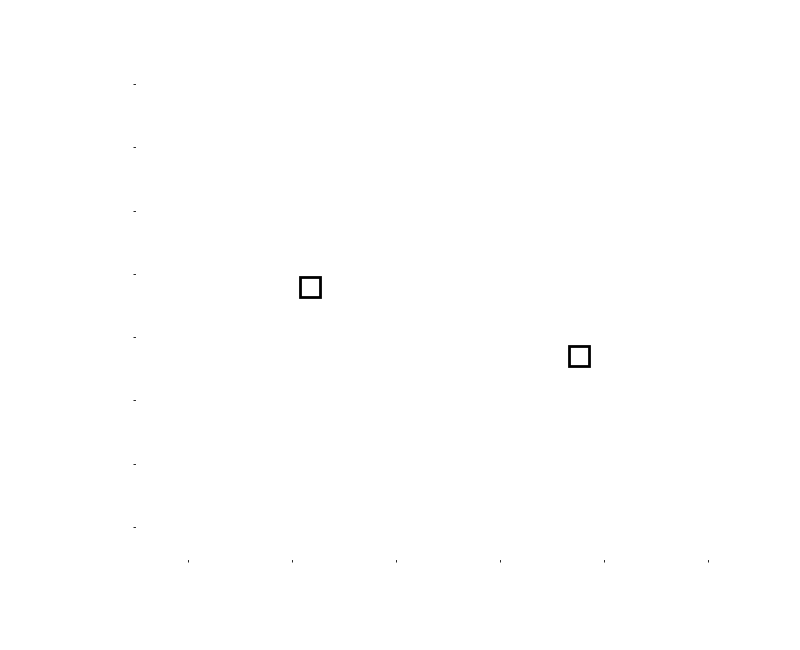

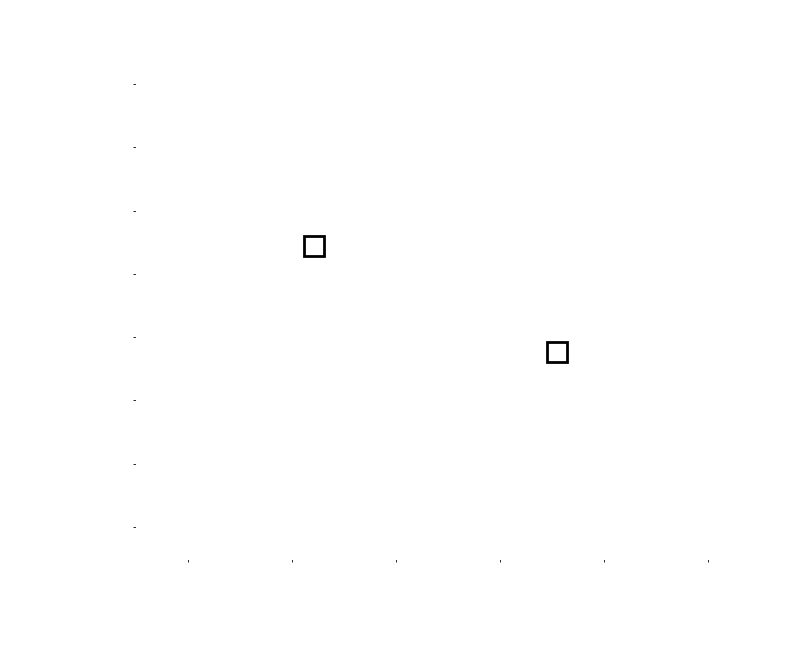

In [56]:
all_sim['global_logmass'] = np.log10(all_sim['globalmass'])#+10
f,(ax1) = plt.subplots(figsize=(8,6.5),sharex=True)
data_highdlr = all_sim[all_sim['d_DLR']>1]
get_step(data_highdlr,'global_logmass',10)
f,ax1=plot_step(data_highdlr,'global_logmass',10,bins=[-0.5,-0.25,0,0.25,0.5,1,1.25,1.5,1.75,2,2.5,3],f=f,ax=ax1,colour='w',bincolour='#ffffff',
                plot_2bin=True,labelext=r' $\log(M/M_{\odot})>10$',
               scatterlabel=False,binlabel=r'Weighted Means')
ax1.vlines(10,-0.2,0.2,ls='--',lw=0.8,color='w')
ax1.set_xlim(9,12)
ax1.set_ylim(-0.2,0.2)
ax1.set_xlabel(r'Host Stellar Mass $\log(M_*/{\rm M}_{\odot})$',size=25,color='w')
ax1.set_ylabel('Hubble Residual ($\mu_{\mathrm{res}}$)',size=25,color='w')
ax1.set_title(r'$d_{\mathrm{DLR}}>1$',size=25,color='w')
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.025))


ax1.spines['bottom'].set_color('white')
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_color('w')
ax1.spines['right'].set_visible(False)
#ax.xaxis.label.set_color('white')
ax1.tick_params( colors='white',labelsize=16,top=False,right=False)

plt.tight_layout()
plt.savefig('figs/toy_sim_outer.png',transparent=True)





f,(ax1) = plt.subplots(figsize=(8,6.5),sharex=True)
data_lowdlr = all_sim[all_sim['d_DLR']<=1]
get_step(data_lowdlr,'global_logmass',10)
f,ax1=plot_step(data_lowdlr,'global_logmass',10,bins=[-0.5,-0.25,0,0.25,0.5,1,1.25,1.5,1.75,2,2.5,3],f=f,ax=ax1,colour='w',bincolour='#ffffff',
                plot_2bin=True,labelext=r' $\log(M/M_{\odot})>10$',
               scatterlabel=False,binlabel=r'Weighted Means')
ax1.vlines(10,-0.2,0.2,ls='--',lw=0.8,color='w')
ax1.set_xlim(9,12)
ax1.set_ylim(-0.2,0.2)
ax1.set_xlabel(r'Host Stellar Mass $\log(M_*/{\rm M}_{\odot})$',size=25,color='w')
ax1.set_ylabel('Hubble Residual ($\mu_{\mathrm{res}}$)',size=25,color='w')
ax1.set_title(r'$d_{\mathrm{DLR}}<1$',size=25,color='w')
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.025))


ax1.spines['bottom'].set_color('white')
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_color('w')
ax1.spines['right'].set_visible(False)
#ax.xaxis.label.set_color('white')
ax1.tick_params( colors='white',labelsize=16,top=False,right=False)

plt.tight_layout()
plt.savefig('figs/toy_sim_inner.png',transparent=True)

In [ ]:
np.mean()

In [ ]:
f,ax=plt.subplots(figsize=(8,8))
boxsizex = h['CDELT1']*h['NAXIS1']/1000
xmin=xmax = boxsizex/2

boxsizey = h['CDELT2']*h['NAXIS2']/1000
ymin=ymax = boxsizex/2
ax.imshow(imggz.T,cmap='RdBu_r',norm='log',origin='lower',extent=[-xmin,xmax,-ymin,ymax],vmin=0.1,vmax=1.2)
ax.scatter(drawn_gals['y_pos'],drawn_gals['x_pos'],marker='o',color='k',s=5,alpha=0.15)
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)

In [ ]:
import astropy.units as u
cosmo.kpc_comoving_per_arcmin(h['USE_Z']).to(u.pc/u.arcsec)*h['PIXSCALE']

In [ ]:
h

In [ ]:
np.nanmax(imggz[np.isfinite(imggz)])
flatgz = imggz.flatten()

In [ ]:
f,ax=plt.subplots(figsize=(8,6.5))
ax.hist(flatgz[np.isfinite(flatgz)],bins=np.arange(-0.25,2.5,0.25),density=True,histtype='step',label='Mock colour',lw=3)
ax.hist(gz,bins=np.arange(-0.25,2.5,0.25),density=True,histtype='step',label='Mock SN apertures',lw=3)
ax.hist(galaxy_catalog['g-z'],bins=np.arange(-0.25,2.5,0.25),density=True,histtype='step',label='Particle g-z',lw=3)
ax.hist(drawn_gals['g-z'],bins=np.arange(-0.25,2.5,0.25),density=True,histtype='step',label='SN particle g-z',lw=3)
ax.legend(fontsize=16)

In [ ]:
from scipy.stats import binned_statistic_2d

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.imshow(hdul[0].data[0].T,cmap='Greys',norm='log',origin='lower',extent=[-xmin,xmax,-ymin,ymax])
ax1.set_xlim(-40,40)
ax1.set_ylim(-40,40)

nPixels=[h['NAXIS1'],h['NAXIS2']]
minMax = [-xmin,xmax]
V_AB = galaxy_catalog['V']+0.79
f_V = 10**((V_AB+48.6)/-2.5)
weights = f_V
grid_temp, _, _, _ = binned_statistic_2d(galaxy_catalog['x_pos']*(1+h['USE_Z']), galaxy_catalog['y_pos']*(1+h['USE_Z']),weights, 'sum', bins=nPixels, range=[minMax,minMax])
grid_temp = -2.5*np.log10(grid_temp)-48.6
extent = [minMax[0], minMax[1], minMax[0], minMax[1]]
ax2.imshow(grid_temp,  extent=extent,cmap='Greys_r', aspect=nPixels[1]/nPixels[0],norm='symlog',origin='lower')

ax2.set_xlim(-40,40)
ax2.set_ylim(-40,40)

In [ ]:
galaxy_catalog['V'].min()

In [ ]:
with h5py.File(f'data/{sim}/stellar_sizes_099.hdf5') as f:
    rhalfs = f['Rhalf'][:]
    #print(np.array(rhalfs))

In [ ]:
import numpy as np

def compute_ellipticity_elongation_for_galaxy(data, galaxy_id):
    """
    Compute the projected ellipticity and elongation for a specific galaxy using the 
    average half-light radii in the r, i, and z bands.
    
    Parameters:
    - data: numpy array of shape (5, 10, N_galaxies)
      The 3D array containing half-light radii for different projections.
    - galaxy_id: int
      The index (ID) of the galaxy for which to compute the properties.
    
    Returns:
    - e_face_edge: float
      Ellipticity comparing face-on and edge-on views for the specific galaxy.
    - e_edge: float
      Ellipticity comparing smallest and largest edge-on projections for the specific galaxy.
    - elongation: float
      Elongation defined as major / minor for the specific galaxy.
    """
    # Extract the half-light radii for the specific galaxy (indexed by galaxy_id)
    r_half_faceon = np.mean(data[0, 6:9, galaxy_id])  # Face-on projection for the specific galaxy
    r_half_largest_edgeon = np.mean(data[1, 6:9, galaxy_id])  # Largest edge-on projection
    r_half_smallest_edgeon = np.mean(data[2, 6:9, galaxy_id])  # Smallest edge-on projection

    # Compute ellipticity for face-on vs. edge-on
    e_face_edge = r_half_faceon/r_half_largest_edgeon

    # Compute ellipticity within the edge-on plane
    e_edge =1- r_half_largest_edgeon/r_half_smallest_edgeon

    # Compute elongation
    elongation = r_half_largest_edgeon / r_half_smallest_edgeon

    return e_face_edge, e_edge, elongation


In [ ]:
results = []
elongs = []
for subhaloId in tqdm(galmeta[galmeta['mass_stars_true']>3E8].index.values):
    results.append(compute_ellipticity_elongation_for_galaxy(rhalfs,subhaloId))
    this_subhalo_morph = galaxy_morphs.iloc[np.where(subfind_ids==subhaloId)[0]]
    try:
        elongs.append(this_subhalo_morph['elongation_asymmetry'].values[0])
    except:
        elongs.append(np.NaN)

In [ ]:
galmeta.loc[galmeta[galmeta['mass_stars_true']>3E8].index,['elong_face_edge','e_edge','elongation']]  = results
galmeta.loc[galmeta[galmeta['mass_stars_true']>3E8].index,'elong_morph'] =elongs

In [ ]:
f,ax=plt.subplots(figsize=(8,6.5))
lowm = galmeta[galmeta['mass_stars_true']<5E9]
ax.scatter(lowm['elong_face_edge'],lowm['elong_morph'],alpha=0.5)
ax.set_xlabel('Computed elongation',size=22)
ax.set_ylabel('Morphological elongation',size=22)
ax.set_ylim(1,3)

In [ ]:
subhaloId = galmeta_mcut.sort_values('mass_stars_true',ascending=False).index[200]
snap_fn =f'data/{sim}/{subhaloId}/cutout_{subhaloId}.hdf5'
#print(os.path.isfile(snap_fn))
subinfo = get(bases[sim]+f'subhalos/{subhaloId}')

with h5py.File(snap_fn) as f:
    #gas=f['PartType0']
    stars=f['PartType4']
    star_inds = np.array(stars['GFM_StellarFormationTime'])>0
    V = stars['GFM_StellarPhotometrics'][star_inds,2]
    x = stars['Coordinates'][star_inds,0] - subinfo['pos_x']
    y = stars['Coordinates'][star_inds,1] - subinfo['pos_y']

hdul = fits.open(f'data/{sim}/{subhaloId}/broadband_{subhaloId}.fits')
h = hdul[0].header


boxsizex = h['CDELT1']*h['NAXIS1']*cosmo.h/1000
xmin=xmax = boxsizex/2

boxsizey = h['CDELT2']*h['NAXIS2']*cosmo.h/1000
ymin=ymax = boxsizex/2
from scipy.stats import binned_statistic_2d

In [ ]:
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter
f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,5),sharex=True,sharey=True)
ax1.imshow(hdul[0].data[0].T,cmap='Greys',norm='log',origin='lower',extent=[-xmin,xmax,-ymin,ymax])
ax1.set_xlim(-40,40)
ax1.set_ylim(-40,40)

nPixels=[h['NAXIS1'],h['NAXIS2']]
minMax = [-xmin,xmax]
V_AB = V+0.79
f_V = 10**((V_AB+48.6)/-2.5)
weights = f_V
grid_temp, _, _, _ = binned_statistic_2d(x*(1+h['USE_Z']), y*(1+h['USE_Z']),weights, 'sum', bins=nPixels, range=[minMax,minMax])
grid_temp = -2.5*np.log10(grid_temp)-48.6
extent = [minMax[0], minMax[1], minMax[0], minMax[1]]
ax2.imshow(grid_temp,  extent=extent,cmap='Greys_r', aspect=nPixels[1]/nPixels[0],norm='symlog',origin='lower')

ax2.set_xlim(-40,40)
ax2.set_ylim(-40,40)




# Apply Gaussian smoothing to match the PSF of a ground-based telescope
pixelscale = h['PIXSCALE']  # arcseconds per pixel
psf_fwhm = 1  # PSF FWHM in arcseconds
sigma = psf_fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0))) / pixelscale  # Convert FWHM to sigma in pixels
weights = f_V
grid_temp, _, _, _ = binned_statistic_2d(x*(1+h['USE_Z']), y*(1+h['USE_Z']),weights, np.nansum, bins=nPixels, range=[minMax,minMax])
#grid_temp = -2.5*np.log10(grid_temp)-48.6
grid_temp = gaussian_filter(grid_temp, sigma=sigma)

extent = [minMax[0], minMax[1], minMax[0], minMax[1]]
ax3.imshow(grid_temp,  extent=extent,cmap='Greys', aspect=nPixels[1]/nPixels[0],norm='log',origin='lower')

ax3.set_xlim(-40,40)
ax3.set_ylim(-40,40)

In [ ]:
from photutils.datasets import make_100gaussians_image
data = grid_temp
background = np.zeros_like(data)

In [ ]:
from photutils.segmentation import detect_sources
threshold=1
segment_map = detect_sources(data, threshold, npixels=100)
f,ax=plt.subplots(figsize=(6,6))
ax.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')

/var/folders/sk/qcx_g_xs2ysbxg4kx0dpy6680000gp/T/ipykernel_48201/917898123.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for n,g in all_sim.groupby(pd.cut(all_sim['d_DLR'],bins=[0,0.5,1,4,])):


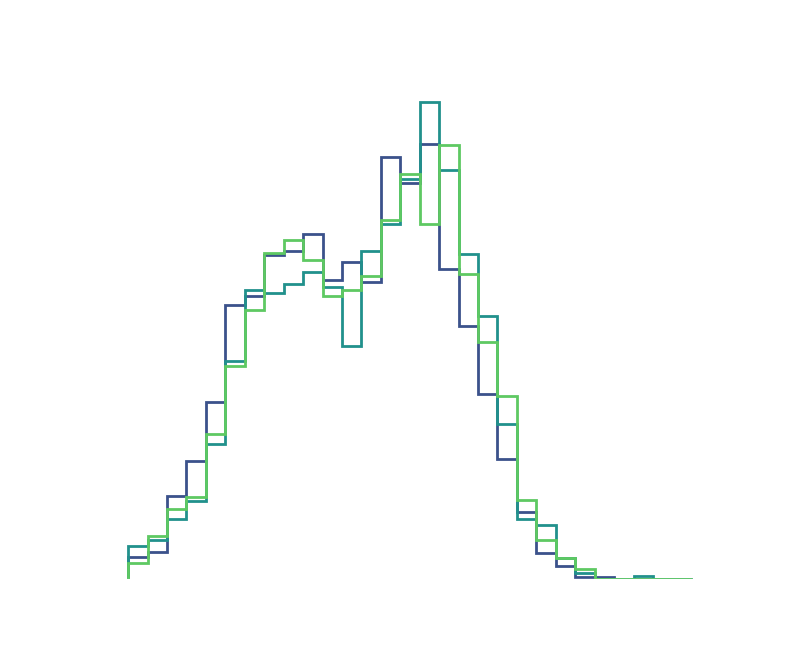

In [29]:
palette = itertools.cycle(sns.color_palette('viridis',n_colors=3))
f,ax=plt.subplots(figsize=(8,6.5))
for n,g in all_sim.groupby(pd.cut(all_sim['d_DLR'],bins=[0,0.5,1,4,])):
    c=next(palette)
    ax.hist(g['x1'],bins=np.linspace(-3,3,30),histtype='step',lw=2,color=c,label=f'${n.left} < d_DLR < {n.right}$',density=True)
#ax.legend()
ax.set_xlabel('SN stretch ($x_1$)',size=22,color='w')
#ax.set_ylabel('Relative Frequency',size=22,color='w')

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_visible(False)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.xaxis.label.set_color('white')
ax.tick_params( colors='white',left=False)
ax.yaxis.set_ticklabels('')

plt.savefig('figs/x1_hists.png',transparent=True)